# Midterm

## Load

In [1279]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import warnings

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.preprocessing import OneHotEncoder,StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score, make_scorer

In [1280]:
warnings.filterwarnings('ignore') # 忽略警告，提高阅读美观性

In [1281]:
# Load data
trainInput = pd.read_csv('Data/ruc_Class25Q1_train.csv')
predInput = pd.read_csv('Data/ruc_Class25Q1_test.csv')
detailInput = pd.read_csv('Data/ruc_Class25Q1_details.csv')

In [1282]:
# 合并detail的数据
train_merge = trainInput.merge(detailInput, how='left', left_on=['小区名称', '区域', '城市','板块'],right_on=['名称', '区县', '城市','板块'])
pred_merge = predInput.merge(detailInput, how='left', left_on=['小区名称', '区域', '城市','板块'],right_on=['名称', '区县', '城市','板块'])

In [1283]:
train_merge.columns

Index(['城市', '区域', '板块', '环线', '小区名称', '价格', '房屋户型', '所在楼层', '建筑面积', '套内面积',
       '房屋朝向', '建筑结构_x', '装修情况', '梯户比例', '配备电梯', '别墅类型', '交易时间', '交易权属',
       '上次交易', '房屋用途', '房屋年限', '产权所属', '抵押信息', '房屋优势', '核心卖点', '户型介绍', '周边配套',
       '交通出行', 'lon', 'lat', '年份', '区县', '名称', '环线位置', '小区地址', '物业类别', '建筑年代',
       '开发商', '房屋总数', '楼栋总数', '物业公司', '绿 化 率', '容 积 率', '物 业 费', '建筑结构_y',
       '物业办公电话', '产权描述', '供水', '供暖', '供电', '燃气费', '供热费', '停车位', '停车费用',
       'coord_x', 'coord_y'],
      dtype='object')

In [1284]:
pred_merge.columns

Index(['ID', '城市', '区域', '板块', '环线', '小区名称', '房屋户型', '所在楼层', '建筑面积', '套内面积',
       '房屋朝向', '建筑结构_x', '装修情况', '梯户比例', '配备电梯', '别墅类型', '交易时间', '交易权属',
       '上次交易', '房屋用途', '房屋年限', '产权所属', '抵押信息', '房屋优势', '核心卖点', '户型介绍', '周边配套',
       '交通出行', 'lon', 'lat', '年份', '区县', '名称', '环线位置', '小区地址', '物业类别', '建筑年代',
       '开发商', '房屋总数', '楼栋总数', '物业公司', '绿 化 率', '容 积 率', '物 业 费', '建筑结构_y',
       '物业办公电话', '产权描述', '供水', '供暖', '供电', '燃气费', '供热费', '停车位', '停车费用',
       'coord_x', 'coord_y'],
      dtype='object')

## Feature Engineering

### Parameters

便于调整数据清理和特征选择的参数

In [1563]:
FEATURE_INDEX = 1 # 选择特征

LNPRICE = True # 价格取对数
LNAREA = True # 面积取对数

AREASQUARE = False # 添加面积二次项

### Features

In [1564]:
features = [
    ['城市','板块','环线','房屋户型','所在楼层','房屋朝向','建筑结构_x','装修情况','配备电梯','别墅类型','交易权属','房屋用途','房屋年限','产权所属'] + ['梯户比例'], #0
    ['城市','板块','小区名称','环线','房屋户型','所在楼层','房屋朝向','建筑结构_x','装修情况','配备电梯','别墅类型','交易权属','房屋用途','房屋年限','产权所属'] + ['梯户比例'] + ['绿 化 率','停车位'] + ['区域'], #1
    ['区域','梯户比例']+['绿 化 率','停车位'],

    ['板块','环线','所在楼层','建筑结构_x','装修情况','产权所属','配备电梯','交易权属','房屋用途','别墅类型'],
    ['区域','环线','所在楼层','建筑结构_x','装修情况','产权所属','配备电梯','交易权属','房屋用途','别墅类型'],
    ['城市','环线','所在楼层','建筑结构_x','装修情况','产权所属','配备电梯','交易权属','房屋用途','别墅类型'],
]

In [1565]:
feature = features[FEATURE_INDEX]
train = train_merge[['价格','建筑面积'] + feature]
pred = pred_merge[['建筑面积'] + feature]

In [1566]:
dummies = ['板块'] # 虚拟变量
# dummies = ['区域']
numeric = []

In [1567]:
train

,价格,建筑面积,城市,板块,小区名称,环线,房屋户型,所在楼层,房屋朝向,建筑结构_x,...,配备电梯,别墅类型,交易权属,房屋用途,房屋年限,产权所属,梯户比例,绿 化 率,停车位,区域
0,6564200,52.3㎡,0,111.0,人定湖西里,二至三环,2室1厅1厨1卫,中楼层 (共5层),南 北,混合结构,...,无,NaN,商品房,普通住宅,满五年,非共有,一梯三户,30%,300.0,79.0
1,4174000,127.44㎡,0,231.0,龙跃苑四区,五至六环,3室1厅1厨1卫,顶层 (共6层),南 北,混合结构,...,无,NaN,商品房,普通住宅,满五年,非共有,一梯两户,30%,1550.0,43.0
2,16310000,228.54㎡,0,54.0,名都园,五至六环,4室2厅1厨4卫,底层 (共3层),南,混合结构,...,无,NaN,商品房,普通住宅,满五年,非共有,一梯一户,30.1%,NaN,97.0
3,2834600,43.6㎡,0,568.0,保利海德公园,三至四环,2房间2卫,低楼层 (共10层),北,钢混结构,...,有,NaN,商品房,商业办公类,满五年,非共有,三梯二十三户,40%,950.0,62.0
4,1954000,39.85㎡,0,226.0,京投银泰琨御府,三至四环,1房间1卫,中楼层 (共10层),南,钢混结构,...,有,NaN,商品房,商业办公类,满五年,非共有,两梯十一户,60%,1800.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84128,1059500,94.12㎡,6,176.0,翡翠明珠,NaN,2室2厅1厨1卫,高楼层 (共33层),东,框架结构,...,有,NaN,商品房,普通住宅,满五年,共有,三梯六户,35%,400.0,71.0
84129,1087900,105.45㎡,6,247.0,明德8英里,二至三环,3室1厅1厨1卫,中楼层 (共30层),东南,钢混结构,...,有,NaN,商品房,普通住宅,满五年,非共有,两梯六户,38%,440.0,93.0
84130,967200,53.8㎡,6,597.0,魏玛公馆,NaN,1室1厅1厨1卫,高楼层 (共32层),北,钢混结构,...,有,NaN,商品房,普通住宅,满五年,非共有,两梯六户,42%,1300.0,46.0
84131,1095000,136.74㎡,6,247.0,万国花园,二至三环,3室3厅1厨2卫,中楼层 (共7层),南 北,混合结构,...,无,NaN,商品房,普通住宅,满五年,非共有,一梯两户,38%,600.0,93.0


### Price

In [1568]:
import seaborn as sns
from scipy.stats import norm
def normplot(data):
    # 创建画布
    plt.figure(figsize=(10, 6))

    # 绘制分布直方图 + KDE曲线
    sns.histplot(data, bins=60, kde=True, stat='density', 
                alpha=0.5, color='skyblue', label='实际分布')

    # 生成正态分布曲线
    mu, std = norm.fit(data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'r--', linewidth=2, label='正态分布')

    # 添加标注
    plt.title('数据分布与正态分布对比', fontsize=14)
    plt.ylabel('密度', fontsize=12)
    plt.legend()

    # 显示图形
    plt.show()

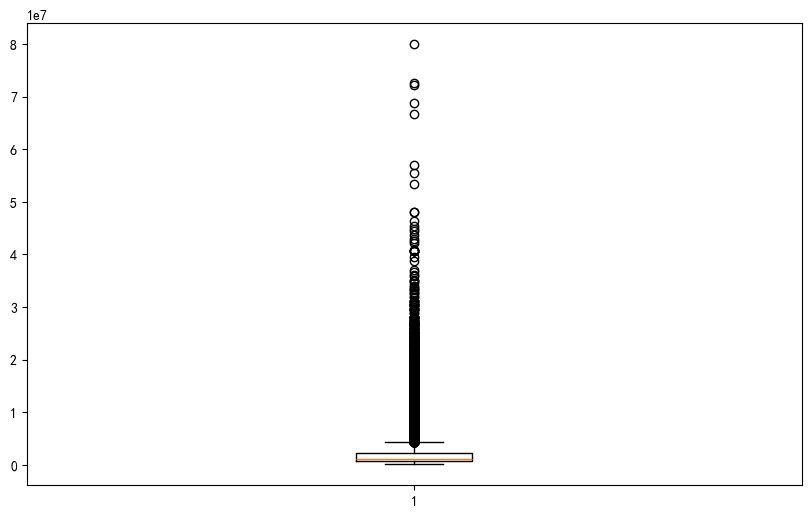

Number of outliers: 8206


In [1569]:
plt.figure(figsize=(10, 6))
plt.boxplot(train['价格'])
plt.show()
Q1 = train['价格'].quantile(0.25)
Q3 = train['价格'].quantile(0.75)
IQR = Q3 - Q1
outliers = train[(train['价格'] < (Q1 - 1.5 * IQR)) | (train['价格'] > (Q3 + 1.5 * IQR))]
print("Number of outliers:", len(outliers))

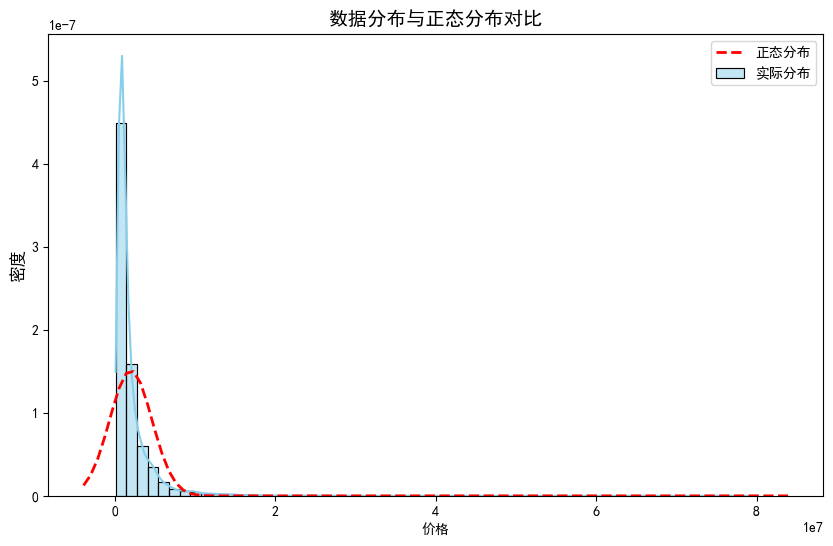

In [1570]:
normplot(train['价格'])

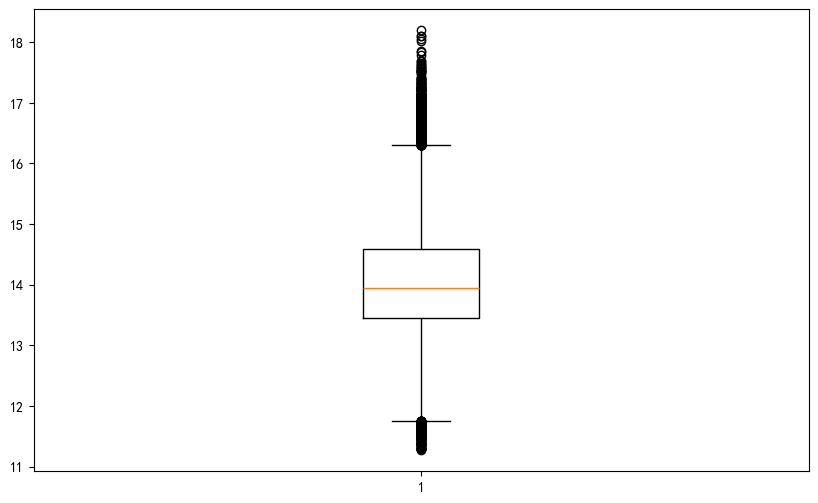

Number of outliers: 1284


In [1571]:
if LNPRICE:
    train['价格'] = np.log(train['价格'])
    plt.figure(figsize=(10, 6))
    plt.boxplot(train['价格'])
    plt.show()
    Q1 = train['价格'].quantile(0.25)
    Q3 = train['价格'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = train[(train['价格'] < (Q1 - 1.5 * IQR)) | (train['价格'] > (Q3 + 1.5 * IQR))]
    print("Number of outliers:", len(outliers))

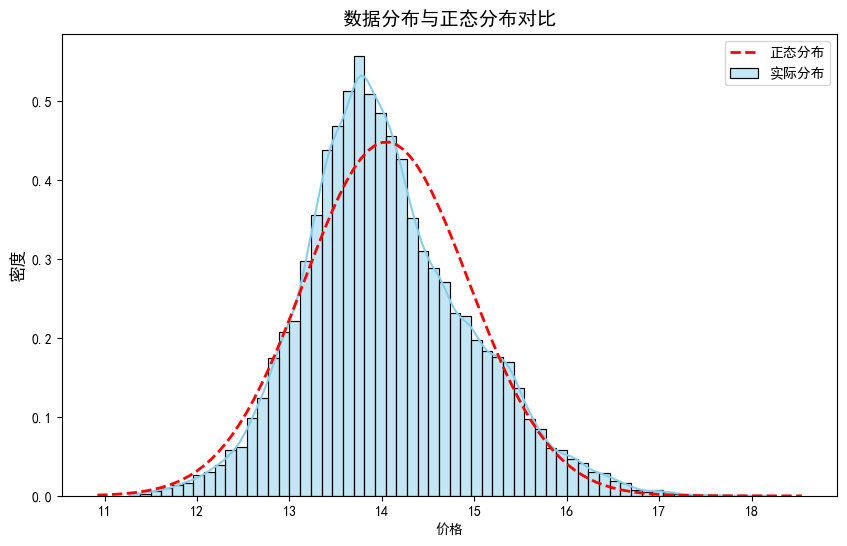

In [1572]:
normplot(train['价格'])

In [1573]:
# Remove the outliers
train = train[~((train['价格'] < (Q1 - 1.5 * IQR)) | (train['价格'] > (Q3 + 1.5 * IQR)))]

### Area

In [1574]:
train['area'] = pd.to_numeric(train['建筑面积'].str.rstrip('㎡'))
train.drop(columns=['建筑面积'], inplace=True)

pred['area'] = pd.to_numeric(pred['建筑面积'].str.rstrip('㎡'))
pred.drop(columns=['建筑面积'], inplace=True)

numeric.append('area')

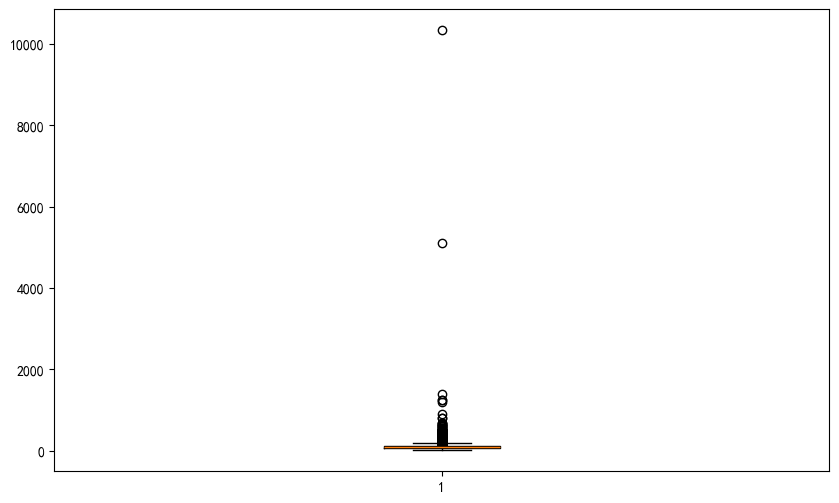

In [1575]:
plt.figure(figsize=(10, 6))
plt.boxplot(train['area'])
plt.show()

In [1576]:
if LNAREA:
    train['area'] = np.log(train['area'])
    pred['area'] = np.log(pred['area'])

if AREASQUARE:
    train['area^2'] = train['area']*train['area']
    pred['area^2'] = pred['area']*pred['area']
    numeric.append('area^2')

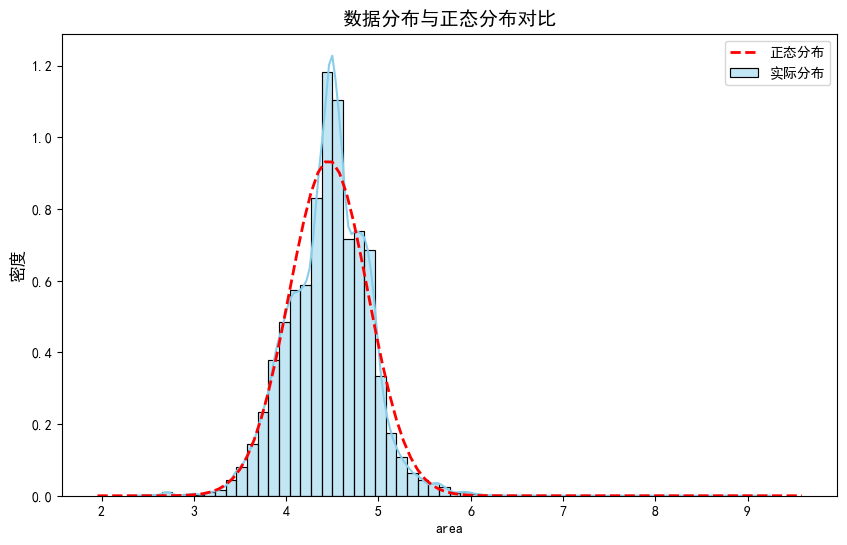

In [1577]:
normplot(train['area'])

### 梯户比例

反映了居住密度

In [1578]:
if '梯户比例' in feature:
    import cn2an
    def to_num(string):
        try:
            ti = cn2an.cn2an(re.findall(r'(.*)梯',string)[0],'smart')
            hu = cn2an.cn2an(re.findall(r'梯(.*)户',string)[0],'smart')
            return ti/hu if hu != 0 else np.nan
        except:
            return np.nan

    train['梯户比例'] = train['梯户比例'].apply(to_num)
    pred['梯户比例'] = pred['梯户比例'].apply(to_num)
    train['梯户比例'] = train['梯户比例'].fillna(train['梯户比例'].median())
    pred['梯户比例'] = pred['梯户比例'].fillna(pred['梯户比例'].median())
    
    numeric.append('梯户比例')

In [1579]:
# dummies.append('梯户比例')

### 绿化率

In [1580]:
if '绿 化 率' in feature:
    train['绿 化 率'] = train['绿 化 率'].str.extract(r'(\d+|\d+\.\d+)%').astype(float)
    median = train['绿 化 率'].median()
    train['绿 化 率'] = train['绿 化 率'].fillna(median)
    train['绿 化 率'] = train['绿 化 率'].apply(lambda x: median if x > 100 else x)
    train['绿 化 率'] = train['绿 化 率'] * 0.01

    pred['绿 化 率'] = pred['绿 化 率'].str.extract(r'(\d+|\d+\.\d+)%').astype(float)
    median = pred['绿 化 率'].median()
    pred['绿 化 率'] = pred['绿 化 率'].fillna(median)
    pred['绿 化 率'] = pred['绿 化 率'].apply(lambda x: median if x > 100 else x)
    pred['绿 化 率'] = pred['绿 化 率'] * 0.01
    
    numeric.append('绿 化 率')

### 停车位

In [1581]:
if '停车位' in feature:
    train['停车位'] = train['停车位'].fillna(train['停车位'].median())
    pred['停车位'] = pred['停车位'].fillna(train['停车位'].median())
    numeric.append('停车位')

### 容积率

最后没有添加这个特征

In [1582]:
if '容 积 率' in feature:
    train['容 积 率'] = train['容 积 率'].fillna(train['容 积 率'].median())
    pred['容 积 率'] = pred['容 积 率'].fillna(pred['容 积 率'].median())
    numeric.append('容 积 率')

### 栋户比

最后没有添加这个特征

In [1583]:
if '楼栋总数' in feature and '房屋总数' in feature:
    train['房屋总数'] = train['房屋总数'].str.extract(r'(\d+)').astype(float)
    train['楼栋总数'] = train['楼栋总数'].str.extract(r'(\d+)').astype(float)
    train['房屋总数'] = train['房屋总数'].fillna(train['房屋总数'].median())
    train['楼栋总数'] = train['楼栋总数'].fillna(train['楼栋总数'].median())
    train['栋户比'] = train['楼栋总数']/train['房屋总数']

    pred['房屋总数'] = pred['房屋总数'].str.extract(r'(\d+)').astype(float)
    pred['楼栋总数'] = pred['楼栋总数'].str.extract(r'(\d+)').astype(float)
    pred['房屋总数'] = pred['房屋总数'].fillna(pred['房屋总数'].median())
    pred['楼栋总数'] = pred['楼栋总数'].fillna(pred['楼栋总数'].median())
    pred['栋户比'] = pred['楼栋总数']/pred['房屋总数']

    train.drop(columns=['楼栋总数','房屋总数'],inplace=True)
    numeric.append('栋户比')

填补缺失值

In [1584]:
train.fillna('未知',inplace=True)
pred.fillna('未知',inplace=True)

### 环线

每个城市的名称相同的环线应为不同的类别。

In [1585]:
if '环线' in feature and '城市' in feature:
    train['环线'] = train['城市'].astype(str) + '_' + train['环线']
    pred['环线'] = pred['城市'].astype(str) + '_' + pred['环线']
    # train.drop(columns=['城市'], inplace=True)
    # pred.drop(columns=['城市'], inplace=True)
    dummies.append('城市')
    dummies.append('环线')

### 房屋户型

In [1586]:
if '房屋户型' in feature:
    # 替换‘房间’为‘室’
    train['房屋户型'] = train['房屋户型'].str.replace('房间','室')
    # 提取具体数量，后续用于生成虚拟变量
    train['n_room'] = train['房屋户型'].str.extract(r'(\d+)室').fillna(0).astype(str)
    train['n_living_room'] = train['房屋户型'].str.extract(r'(\d+)厅').fillna(0).astype(str)
    train['n_kitchen'] = train['房屋户型'].str.extract(r'(\d+)厨').fillna(0).astype(str)
    train['n_bathroom'] = train['房屋户型'].str.extract(r'(\d+)卫').fillna(0).astype(str)
    train.drop(columns=['房屋户型'], inplace=True)
    # 对预测集进行相同操作
    pred['房屋户型'] = pred['房屋户型'].str.replace('房间','室')
    pred['n_room'] = pred['房屋户型'].str.extract(r'(\d+)室').fillna(0).astype(str)
    pred['n_living_room'] = pred['房屋户型'].str.extract(r'(\d+)厅').fillna(0).astype(str)
    pred['n_kitchen'] = pred['房屋户型'].str.extract(r'(\d+)厨').fillna(0).astype(str)
    pred['n_bathroom'] = pred['房屋户型'].str.extract(r'(\d+)卫').fillna(0).astype(str)
    pred.drop(columns=['房屋户型'], inplace=True)

    dummies.append('n_room')
    dummies.append('n_living_room')
    dummies.append('n_kitchen')
    dummies.append('n_bathroom')

### 所在楼层

In [1587]:
# if '所在楼层' in feature:
#     train['所在楼层'] = train['所在楼层'].str.extract(r'(.*?)\s')
#     pred['所在楼层'] = pred['所在楼层'].str.extract(r'(.*?)\s')
#     dummies.append('所在楼层')

经过测试发现，不对“所在楼层”这一特征进行处理，performance稍微有所改善。

In [1588]:
if '所在楼层' in feature:
    dummies.append('所在楼层')

### 房屋朝向

In [1589]:
if '房屋朝向' in feature:
    for direction in ['东','南','西','北','东北','东南','西南','西北']:
        train['房屋朝向_'+direction] = train['房屋朝向'].apply(lambda x: True if direction in x else False)
        pred['房屋朝向_'+direction] = pred['房屋朝向'].apply(lambda x: True if direction in x else False)

    train.drop(columns=['房屋朝向'], inplace=True)
    pred.drop(columns=['房屋朝向'], inplace=True)

### 建筑结构、装修情况、配备电梯、别墅类型、交易权属、房屋用途、房屋年限、产权所属、小区名称

这些特征可以直接取虚拟变量，不需要特别处理。

In [1590]:
for f in ['小区名称','建筑结构_x','装修情况','配备电梯','别墅类型','交易权属','房屋用途','房屋年限','产权所属','区域']:
    if f in feature:
        dummies.append(f)

In [1591]:
train.columns

Index(['价格', '城市', '板块', '小区名称', '环线', '所在楼层', '建筑结构_x', '装修情况', '配备电梯',
       '别墅类型', '交易权属', '房屋用途', '房屋年限', '产权所属', '梯户比例', '绿 化 率', '停车位', '区域',
       'area', 'n_room', 'n_living_room', 'n_kitchen', 'n_bathroom', '房屋朝向_东',
       '房屋朝向_南', '房屋朝向_西', '房屋朝向_北', '房屋朝向_东北', '房屋朝向_东南', '房屋朝向_西南',
       '房屋朝向_西北'],
      dtype='object')

## Linear Models

### Split data

In [1527]:
def Scores(ytest ,y_pred):
    if LNPRICE:
        mse = mean_squared_error(np.exp(ytest),np.exp(y_pred))
        mae = mean_absolute_error(np.exp(ytest),np.exp(y_pred))
        r2 = r2_score(np.exp(ytest),np.exp(y_pred))
    else:
        mse = mean_squared_error(ytest,y_pred)
        mae = mean_absolute_error(ytest,y_pred)
        r2 = r2_score(ytest,y_pred)
    return {'MSE':mse,'MAE':mae,'r2':r2}

In [1528]:
y = train['价格']
train.drop(columns=['价格'], inplace = True)

mse = 0
mae = 0
r2 = 0

Xtrain, Xtest, ytrain, ytest = train_test_split(train, y, test_size=0.2, random_state=111)

In [1529]:
kf = KFold(n_splits=6, shuffle=True, random_state=111)
def exp_mae(y_true, y_pred_log):
    y_pred_log = pd.DataFrame(y_pred_log)
    y_pred = np.exp(y_pred_log)
    return mean_absolute_error(y_true, y_pred)

mae_scorer = make_scorer(exp_mae, greater_is_better=False)

### Linear Regression

In [1530]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(drop='first',handle_unknown='ignore'), dummies)
    ])

ols = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    # ('interaction', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('regressor',  LinearRegression())
])

ols.fit(Xtrain,ytrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['area', '梯户比例', '绿 化 率',
                                                   '停车位']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['板块', '城市', '环线', 'n_room',
                                                   'n_living_room', 'n_kitchen',
                                                   'n_bathroom', '所在楼层', '小区名称',
                                                   '建筑结构_x', '装修情况', '配备电梯',
                                                   '别墅类型', '交易权属', '房屋用途',
                                                   '房屋年限', '产权所属', '区域'])])),
                ('regressor', LinearRegression())])

In [1531]:
print(Scores(ytrain,ols.predict(Xtrain)))

y_pred = ols.predict(Xtest)
print(Scores(ytest,y_pred))

{'MSE': 102597963998.02797, 'MAE': 143463.77196820924, 'r2': 0.9680402951315473}
{'MSE': 105622003743.1426, 'MAE': 156846.77976482568, 'r2': 0.9671462288859447}


In [1532]:
yols = ols.predict(pred)
yols = pd.DataFrame(yols)

if LNPRICE:
    yols = np.exp(yols)

yols.to_csv('ols_output.csv',header=['Price'],index=True,index_label='ID')

In [1533]:
OLSCVscores = -1 * cross_val_score(Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor',  LinearRegression())
]), train, y, cv=kf, scoring=mae_scorer, n_jobs=-1)
print(OLSCVscores,OLSCVscores.mean())

[1763439.89662989 1725902.83171122 1774266.76390589 1779682.62900419
 1766503.22117303 1787533.82439228] 1766221.5278027488


### Lasso

Datahub score: 76.566 (alpha = 0.0001)  
79.55400 (alpha = 0.00001)

In [ ]:
LASSOALPHA = 1e-4

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(drop='first',handle_unknown='ignore'), dummies)
    ])

lasso = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor',  Lasso(alpha=LASSOALPHA, random_state=111))
])

lasso.fit(Xtrain,ytrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['area', '梯户比例', '绿 化 率',
                                                   '停车位']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['板块', '环线', 'n_room',
                                                   'n_living_room', 'n_kitchen',
                                                   'n_bathroom', '所在楼层', '小区名称',
                                                   '建筑结构_x', '装修情况', '配备电梯',
                                                   '别墅类型', '交易权属', '房屋用途',
                                                   '房屋年限', '产权所属', '区域'])])),
                ('regressor', Lasso(alpha=0.0001, random_state=111))])

In [ ]:
print(Scores(ytrain,lasso.predict(Xtrain)))

y_pred = lasso.predict(Xtest)
print(Scores(ytest,y_pred))

{'MSE': 263467727532.32468, 'MAE': 238477.15085143517, 'r2': 0.9179286753248159}
{'MSE': 225546546735.81445, 'MAE': 236533.92198587753, 'r2': 0.9298436465942815}


In [ ]:
ylasso = lasso.predict(pred)
ylasso = pd.DataFrame(ylasso)

if LNPRICE:
    ylasso = np.exp(ylasso)

ylasso.to_csv('lasso_output.csv',header=['Price'],index=True,index_label='ID')

In [ ]:
LASSOCVscores = -1 * cross_val_score(Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor',  Lasso(alpha=LASSOALPHA, random_state=111))
]), train, y, cv=kf, scoring=mae_scorer, n_jobs=-1)
print(LASSOCVscores,LASSOCVscores.mean())

[1729371.61399197 1694320.3018019  1748097.42998674 1744679.78807898
 1734506.04970437 1751810.49626479] 1733797.6133047908


### Ridge

Datahub scores:  
0.05 80.902  
0.1 80.921  
0.5 80.794  
0.01 80.988  
0.001 80.98400

In [ ]:
RIDGEALPHA = 0.001

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(drop='first',handle_unknown='ignore'), dummies)
    ])

ridge = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor',  Ridge(alpha=RIDGEALPHA, random_state=111))
])

ridge.fit(Xtrain,ytrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['area', '梯户比例', '绿 化 率',
                                                   '停车位']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['板块', '城市', '环线', 'n_room',
                                                   'n_living_room', 'n_kitchen',
                                                   'n_bathroom', '所在楼层', '小区名称',
                                                   '建筑结构_x', '装修情况', '配备电梯',
                                                   '别墅类型', '交易权属', '房屋用途',
                                                   '房屋年限', '产权所属', '区域'])])),
                ('regressor', Ridge(alpha=0.001, random_state=111))])

In [ ]:
print(Scores(ytrain,ridge.predict(Xtrain)))

y_pred = ridge.predict(Xtest)
print(Scores(ytest,y_pred))

{'MSE': 102806065963.5755, 'MAE': 143683.29703537238, 'r2': 0.9679754704786764}
{'MSE': 105999111228.41826, 'MAE': 156802.60560025933, 'r2': 0.9670289294353797}


In [ ]:
yridge = ridge.predict(pred)
yridge = pd.DataFrame(yridge)

if LNPRICE:
    yridge = np.exp(yridge)

yridge.to_csv('ridge_output.csv',header=['Price'],index=True,index_label='ID')

In [ ]:
RIDGECVscores = -1 * cross_val_score(Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor',  Ridge(alpha=RIDGEALPHA, random_state=111))
]), train, y, cv=kf, scoring=mae_scorer, n_jobs=-1)
print(RIDGECVscores,RIDGECVscores.mean())

[1763462.6410133  1725704.02113262 1774430.45019707 1779576.40513327
 1766756.17757925 1787619.63786613] 1766258.2221536068


### Elastic Net

Datahub score: 75.53500 (alpha = 0.001 l1-ratio = 0)

In [ ]:
EN_ALPHA = 0.001
L1_RATION = 0

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(drop='first',handle_unknown='ignore'), dummies)
    ])

en = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor',  ElasticNet(alpha=EN_ALPHA, l1_ratio=L1_RATION, random_state=111))
])

en.fit(Xtrain,ytrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['area', '梯户比例', '绿 化 率',
                                                   '停车位']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['板块', '环线', 'n_room',
                                                   'n_living_room', 'n_kitchen',
                                                   'n_bathroom', '所在楼层', '小区名称',
                                                   '建筑结构_x', '装修情况', '配备电梯',
                                                   '别墅类型', '交易权属', '房屋用途',
                                                   '房屋年限', '产权所属', '区域'])])),
                ('regressor',
                 ElasticNet(alpha=0.001, l1_ratio=0, random_state=111))])

In [ ]:
print(Scores(ytrain,en.predict(Xtrain)))

y_pred = en.predict(Xtest)
print(Scores(ytest,y_pred))

{'MSE': 284304744032.5809, 'MAE': 243465.06904525627, 'r2': 0.9114378555099114}
{'MSE': 249610321221.9125, 'MAE': 242668.25297969911, 'r2': 0.9223585988666404}


In [ ]:
yen = en.predict(pred)
yen = pd.DataFrame(yen)

if LNPRICE:
    yen = np.exp(yen)

yen.to_csv('en_output.csv',header=['Price'],index=True,index_label='ID')

In [ ]:
ENCVscores = -1 * cross_val_score(Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor',  ElasticNet(alpha=EN_ALPHA, l1_ratio=L1_RATION, random_state=111))
]), train, y, cv=kf, scoring=mae_scorer, n_jobs=-1)
print(ENCVscores,ENCVscores.mean())

[1701293.45101977 1667820.02913798 1716848.7169491  1715629.05683995
 1702816.58142057 1722755.16431949] 1704527.1666144775
